sugerencias de clasificación binaria con imágenes de queries en google:
    
- plant/tree
- nature/city
- futbol/baloncesto
- doritos/detodito
- people with glasses/portrait

experimentos:

- imágenes de 64x64, 128x128
- más imágenes
- más capas (Dense/Convolucionales)
- más dropout cuando veas overfitting

Sube el notebook a tu drive y ejecútalo con Google Colab

In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 304kB/s ta 0:00:01
  Running setup.py bdist_wheel for google-images-download ... done
  Stored in directory: /home/user/.cache/pip/wheels/aa/68/b6/913b8a4e2b20c028bf54d3765cd58297c6e7f16323f1827cbe
Successfully built google-images-download
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Visualizar imagenes en mosaico

In [181]:
def show_image_mosaic(imgs, labels, figsize=(12, 12), idxs=None):

    plt.figure(figsize=figsize)
    for labi,lab in [i for i in enumerate(np.unique(labels))]:
        k = imgs[labels == lab]
        _idxs = idxs[:10] if idxs is not None else np.random.permutation(len(k))[:10]
        for i, idx in enumerate(_idxs):
            if i == 0:
                plt.subplot(10, 11, labi*11+1)
                plt.title("LABEL %d" % lab)
                plt.plot(0, 0)
                plt.axis("off")

            img = k[idx]
            plt.subplot(10, 11, labi*11+i+2)
            plt.imshow(img, cmap=plt.cm.Greys_r)
            plt.axis("off")

# Descarga de imagenes de la web

In [182]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [183]:
cfg="""
{
    "Records": [
        {
            "keywords": "ship",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "plane",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [184]:
!rm -rf $downloads
!mkdir $downloads
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [185]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = ship
Evaluating...
Starting Download...
Completed Image ====> 1. cruise-ship-cruiser-cruise-ship-144237.jpeg
Completed Image ====> 2. hero_bliss_072618.jpg
Completed Image ====> 3. norwegian-cruise.jpg
Completed Image ====> 4. cruise-903908.jpg
Completed Image ====> 5. cunard-new-ship-solo-966x442-v3.jpg
Completed Image ====> 6. eight_col_kea_trader.jpg
Completed Image ====> 7. 368f7911b809dd2cb6b5a70ca0a35a6c?width=1024.jpg
Completed Image ====> 8. cabo-cruiseship-schedule.jpg
Completed Image ====> 9. wind-spirit.jpg
Completed Image ====> 10. ship-3455779__340.jpg
Completed Image ====> 11. 536-large-65658fde58ab3c2b6e5132a39fae7cb9.jpg
Completed Image ====> 12. silver-cloud.jpg
Completed Image ====> 13. 1519003265163.jpg
Completed Image ====> 14. amerigo-vespucci.jpg
Completed Image ====> 15. 1200px-container_ship_reecon_whale_on_black_sea_near_constan%c8%9ba_romania.jpg
Completed Image ====> 16. nsmv-1.jpg
Completed Image ====> 17. cruise-news-royal-carib

# Se revisan las imagenes y se eliminan las defectuosas

In [186]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print ".",
        try:
            io.imread(fname)
        except:
            print "\nremoving",fname,"as cannot be read\n"
            !rm '$fname'

. . . . . . . . . . . . . . . . 
removing /tmp/downloads/plane/20. ifilpb64_airbus-beluga-xl_625x300_20_july_18.jpg as cannot be read

. . . . . . . . . . . . . . . 
removing /tmp/downloads/plane/36. nasa-quesst-supersonic-plane-2017.jpg as cannot be read

. . . . . . 
removing /tmp/downloads/plane/1. white-plane-sky.jpg as cannot be read

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/ship/7. 368f7911b809dd2cb6b5a70ca0a35a6c?width=1024.jpg as cannot be read

. . . . . . . . . . . . . . .


## Organizamos las imagenes en train y test

In [187]:
classdirs = !find $downloads -type d
classdirs = ['"'+i.split("/")[-1]+'"' for i in classdirs if i!=downloads]
print classdirs

['"plane"', '"ship"']


In [188]:
!rm -rf $traintest_imgs

In [189]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

"plane"
    splitting files ...  copying files
"ship"
    splitting files ...  copying files


### sanity check 1

In [190]:
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

"plane"
       32 train images
       15 test images
"ship"
       34 train images
       15 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [191]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [192]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
#datagen.fit() with zca_whitening = True to fit
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 32x32
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary'
        ) 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 32X32
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary'
        ) 

(10, 32, 32, 3)
(10,)
Found 66 images belonging to 2 classes.


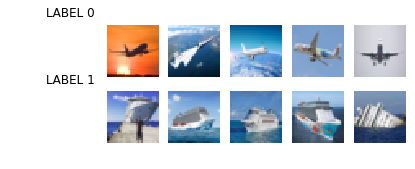

In [194]:
print imgs.shape
print labels.shape
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
        
show_image_mosaic(imgs, labels)


# Definimos el modelo -  Convolutional

In [202]:
def get_conv_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(6,(14,14), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layers)
    layers = tf.keras.layers.Conv2D(16,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layers)
    layers = tf.keras.layers.Conv2D(2,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layers)

    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [203]:
model = get_conv_model(2, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 66 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 15s 155ms/step - loss: 0.6165 - acc: 0.6680 - val_loss: 0.5890 - val_acc: 0.7375
Epoch 2/5
100/100 [==============================] - 14s 142ms/step - loss: 0.3775 - acc: 0.8634 - val_loss: 0.5411 - val_acc: 0.7025
Epoch 3/5
100/100 [==============================] - 14s 140ms/step - loss: 0.2176 - acc: 0.9417 - val_loss: 0.6004 - val_acc: 0.6625
Epoch 4/5
100/100 [==============================] - 14s 137ms/step - loss: 0.1357 - acc: 0.9823 - val_loss: 0.6161 - val_acc: 0.6975
Epoch 5/5
100/100 [==============================] - 13s 133ms/step - loss: 0.0877 - acc: 0.9837 - val_loss: 0.6180 - val_acc: 0.8050


### predictions

In [204]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=0.7, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 30 images belonging to 2 classes.
[[ 2.2660942 97.73391  ]
 [14.633923  85.36608  ]
 [45.856197  54.143803 ]
 [99.35059    0.6494076]
 [10.75753   89.24246  ]
 [29.069424  70.93057  ]
 [61.3188    38.681194 ]
 [91.04484    8.955168 ]
 [98.02288    1.9771246]
 [ 3.2934864 96.70651  ]]
[1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         0.99999994]


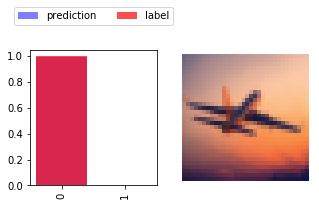

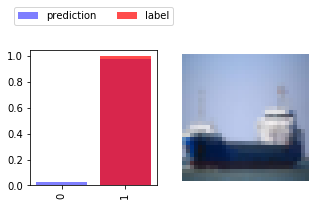

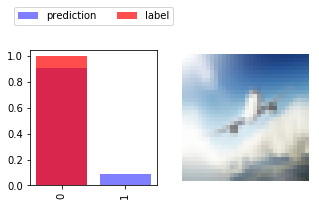

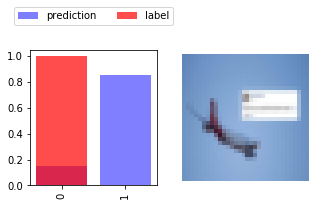

In [205]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
print preds*100
print preds.sum(axis=1)
show_preds(x, preds)